In [1]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import datetime
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import seaborn as sns
from tqdm import tqdm
from scipy.ndimage import center_of_mass

In [2]:
cases_admiss = {}
admiss_occup = {}

In [3]:
# download api data
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=hospitalCases&metric=newAdmissions&metric=newCasesBySpecimenDate&format=json" #&release=2021-06-02"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df = pd.DataFrame(response['body'])
df['dateTime'] = pd.to_datetime(df['date'])
df.sort_values(by=['dateTime'], inplace=True)
df.dropna(inplace=True)

x_dateTimes = sorted(list(set(df.dateTime.to_list())))
top_date = x_dateTimes[-1].strftime("%Y-%m-%d")
print(top_date)

2021-06-29


In [20]:
waves = [
    {"start":"2020-08-01", "end":top_date},    
    {},
    {"start":"2020-11-01", "end":"2021-03-01"},    
    {"start":"2020-11-01", "end":top_date},
    {"start":"2021-05-01", "end":top_date}
]

wave = 3
start_date = waves[wave]["start"]
end_date = waves[wave]["end"]

_df = df[(df.dateTime >= start_date) & (df.dateTime <= end_date)]
cases_stream = np.array(_df.newCasesBySpecimenDate.to_list(), dtype=int)
admissions_stream = np.array(_df.newAdmissions.to_list(), dtype=int)
occupancy_stream = np.array(_df.hospitalCases.to_list(), dtype=int)
#occupancy_stream -= occupancy_stream[0]

def N_avg(a, N=7):
    # weekly avg into the past
    b = np.zeros(len(a)-N)
    for i in range(N,len(a),1):
        b[i-N] = np.mean(a[i-N:i])
    return b

#cases_stream = N_avg(cases_stream)
#admissions_stream = N_avg(admissions_stream)
#occupancy_stream = N_avg(occupancy_stream)

print(cases_stream)
print(admissions_stream)
print(occupancy_stream)
print(len(occupancy_stream))

[13369 27925 22304 20693 20876 20827 16620 17960 28095 24465 24644 21949
 21651 16033 14211 23728 20325 18217 15505 14676 10615 10037 16208 14028
 13934 12275 12264  9203  8907 15030 13517 13463 12528 12884 10141 10871
 17393 16675 17462 18547 19865 16031 18129 29520 29097 30126 29594 31826
 21737 28939 42585 40905 37623 28699 12675 36704 42438 40036 72506 62896
 46682 28222 54164 49516 69110 58040 51313 46831 42328 35440 32852 51995
 44680 41147 38517 36789 27655 26207 40724 35966 31754 28756 26907 19876
 15454 27105 24430 23239 21847 19681 15000 13708 20111 17656 17413 16151
 13970 10582 10136 13837 12242 11839 11223 10565  7742  7534 12466 10815
 10022  9904  8880  6890  6798  9856  8141  7291  6611  5666  4103  3952
  5888  5680  5096  4790  4552  3702  3528  5563  5211  5007  4687  4614
  3449  3584  5437  4740  4852  4523  4138  3368  4516  5142  4337  5105
  4444  3621  2942  4093  3203  2953  3140  2863  2128  2016  1925  2188
  2561  2584  2478  2313  1890  1896  2232  1906  1

In [30]:
def _f(x, in_stream, out_stream):
    # model out_stream as a convolution of in_stream with x
    target_out_stream = out_stream[len(x)-1:]
    pred_out_stream = np.convolve(in_stream, x, mode="valid")
    return target_out_stream, pred_out_stream

def f(xs, in_stream=cases_stream, out_stream=admissions_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _f(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret        

In [31]:
n_dim = 30
n_particles = 1000

x_max = 0.1*np.ones(n_dim)
x_min = np.zeros(n_dim)
options = {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
bounds = (x_min, x_max)
init_pos = np.array([x_min for i in range(n_particles)])

cases_admiss_outputs = []

In [32]:
for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(f, 1000, verbose=True, n_processes=10)
    cases_admiss_outputs.append(pos)
cases_admiss_outputs = np.array(cases_admiss_outputs)

2021-07-02 09:33:20,575 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=127 
2021-07-02 09:33:25,602 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 126.74584359832049, best pos: [0.01559903 0.00530667 0.00414317 0.00313312 0.003032   0.00780991
 0.00488141 0.00182489 0.00148241 0.00160481 0.00441003 0.0018997
 0.00160957 0.00579075 0.00182063 0.00119479 0.00397784 0.0019432
 0.00055699 0.00222179 0.00114856 0.00058111 0.00067713 0.00133174
 0.00053466 0.00172437 0.00122134 0.00108041 0.00082735 0.00225029]
2021-07-02 09:33:25,608 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=126 
2021-07-02 09:33:30,719 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 125.86590800973782, best pos: [0.00880121 0.0069

2021-07-02 09:34:29,115 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=133 
2021-07-02 09:34:34,381 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 133.46380119070335, best pos: [0.01305844 0.00855173 0.00285203 0.00645085 0.0035216  0.00640673
 0.0026443  0.00210782 0.00341231 0.00388869 0.0010786  0.00257914
 0.00269184 0.00162685 0.00160967 0.00099239 0.00305934 0.00110438
 0.00130087 0.00091753 0.00224681 0.0014571  0.00132931 0.00166314
 0.00070051 0.00135164 0.00200878 0.00164112 0.0019567  0.00151347]
2021-07-02 09:34:34,388 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=135 
2021-07-02 09:34:39,449 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 135.1327283520729, best pos: [0.01159925 0.005

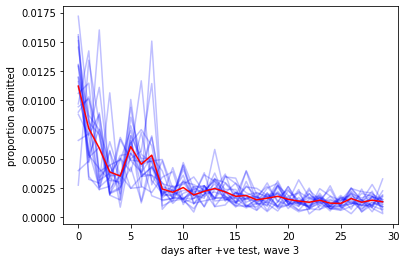

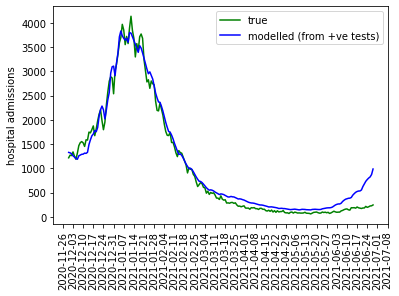

In [36]:
plt.clf()
x = list(range(len(pos)))
for y in cases_admiss_outputs:
    #print(sum(y))
    plt.plot(x, y, color="blue", alpha=0.25)
y_avg_cases_admiss = []
for i in range(len(y)):
    y_avg_cases_admiss.append(np.mean(cases_admiss_outputs[:,i]))
plt.plot(x, y_avg_cases_admiss, color="red", alpha=1)
plt.xlabel("days after +ve test, wave %d" % wave)
plt.ylabel("proportion admitted")
plt.savefig("cases_admiss_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

plt.clf()
true, pred = _f(y_avg_cases_admiss, cases_stream, admissions_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true, color="green", label="true")
plt.plot(x, pred, color="blue", label="modelled (from +ve tests)")
#plt.xlabel("days after start of wave %d" % wave)
plt.ylabel("hospital admissions")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.savefig("cases_admiss_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()


cases_admiss[wave] = y_avg_cases_admiss

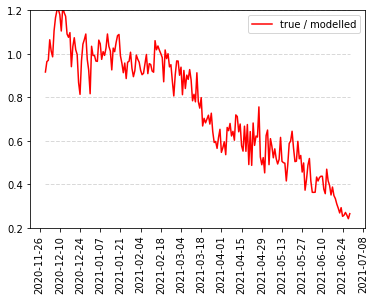

0.26504038517724093


In [40]:
plt.clf()
true, pred = _f(cases_admiss[2], cases_stream, admissions_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true/pred, color="red", label="true / modelled")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(14))
plt.ylim(0.2,1.2)
y_locs,_ = plt.yticks()
plt.hlines(y_locs, x[0], x[-1], color="black", linestyles='dashed', alpha=0.15, linewidth=1)
plt.savefig("cases_admiss_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

print((true/pred)[-1])

2 0.08588858208692993 (9.05192939643298,)
3 0.08588858208692993 (9.05192939643298,)


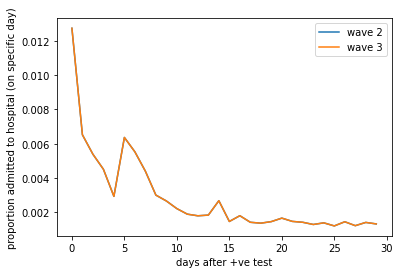

In [22]:
for wave,y_avg_cases_admiss in cases_admiss.items():
    print(wave, np.sum(y_avg_cases_admiss), center_of_mass(np.array(y_avg_cases_admiss)))
          
plt.clf()
x = range(n_dim)
for wave,y_avg_cases_admiss in cases_admiss.items():
    plt.plot(x, y_avg_cases_admiss, label="wave %d" % wave)
plt.xlabel("days after +ve test")
plt.ylabel("proportion admitted to hospital (on specific day)")
plt.legend()
plt.savefig("cases_admiss_compare.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

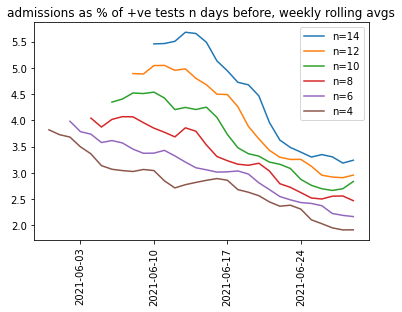

In [51]:
x_dateTimes = df.dateTime.to_list()[-len(x)-11:]

y = {}
admiss_rolling = {}
cases_rolling = {}
for n in [14,12,10,8,6,4]:
    _y1 = []
    _y2 = []
    _y = []
    for dateTime in x_dateTimes[n+7:]:
        dateTime1 = dateTime - datetime.timedelta(days=8)
        dateTime2 = dateTime 
        y1 = np.sum(df[(df.dateTime<=dateTime2) & (df.dateTime>dateTime1)].newAdmissions.to_list())
        _y1.append(y1/7)
        dateTime1 = dateTime1 - datetime.timedelta(days=n)
        dateTime2 = dateTime2 - datetime.timedelta(days=n)
        y2 = np.sum(df[(df.dateTime<=dateTime2) & (df.dateTime>dateTime1)].newCasesBySpecimenDate.to_list())
        _y2.append(y2/7)
        _y.append(y1/y2)
    y[n] = np.array(_y)
    admiss_rolling[n] = np.array(_y1)
    cases_rolling[n] = np.array(_y2)

plt.clf()
plt.title("admissions as % of +ve tests n days before, weekly rolling avgs")
for n,_y in y.items():
    plt.plot(x_dateTimes[n+7:], _y*100, label="n=%d" % n)
true, pred = _f(cases_admiss[2], cases_stream, admissions_stream) 
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(7))
#plt.ylim(2,None)
plt.legend()
plt.savefig("test_vs_admiss_n_days_ago", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()



In [7]:
def cumsumflip(x):
    return np.flip(np.cumsum(np.flip(x)))

def _g(x, in_stream, out_stream):
    # model each 1 from in_stream as remaining present for a period with distribution x, in out_stream
    target_out_stream = out_stream[len(x)-1:]
    _x = cumsumflip(x)
    pred_out_stream = np.convolve(in_stream, _x, mode="valid")
    return target_out_stream, pred_out_stream

def g(xs, in_stream=admissions_stream, out_stream=occupancy_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _g(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
        ret[i] += 1e4*abs(1-np.sum(x)) if np.sum(x)>1 else 0
    return ret    

print(_g(np.array([0.5,0.6]), [1,1,1,3,3,3], [0,1,2,3,4,5]))

([1, 2, 3, 4, 5], array([1.7, 1.7, 3.9, 5.1, 5.1]))


In [14]:
n_dim = 30
n_particles = 1000

x_max = 0.25*np.ones(n_dim)
x_min = -0.05*np.ones(n_dim)
options = {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
bounds = (x_min, x_max)
init_pos = np.array([x_min for i in range(n_particles)])

admiss_occup_outputs = []

In [15]:
for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(g, 1000, verbose=True, n_processes=11)
    admiss_occup_outputs.append(pos)
admiss_occup_outputs = np.array(admiss_occup_outputs)

2021-07-02 12:52:11,145 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=479  
2021-07-02 12:52:18,672 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 479.218569026083, best pos: [-0.03235003  0.04432557  0.06755669  0.06218248  0.18828481  0.13877059
  0.02726411  0.04795448  0.01614395  0.09676947 -0.00801552  0.0466539
  0.02321582  0.00124944  0.08326546 -0.03429746  0.06585066  0.01163576
 -0.03133853 -0.03650324  0.00963225 -0.02785474  0.02658451  0.01352391
 -0.01019034  0.01035887 -0.0061637   0.03739794 -0.00260419  0.10030655]
2021-07-02 12:52:18,678 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=531  
2021-07-02 12:52:26,254 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 531.18815372544

2021-07-02 12:53:42,418 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=569   
2021-07-02 12:53:49,998 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 569.3438379401415, best pos: [ 0.07866469 -0.02956057  0.12941353  0.01476571 -0.00562507  0.21019385
  0.06506403  0.16233138 -0.02387612  0.02131574 -0.04906256 -0.02212048
  0.05588691  0.0164296   0.1594287   0.00242505 -0.01255002 -0.00117693
 -0.0390634  -0.02764773  0.09105627  0.13192733 -0.02491695 -0.02650334
 -0.02059    -0.01882728  0.06632079 -0.01629334 -0.01090521  0.05630513]
2021-07-02 12:53:50,005 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=469  
2021-07-02 12:53:57,349 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 469.03817107

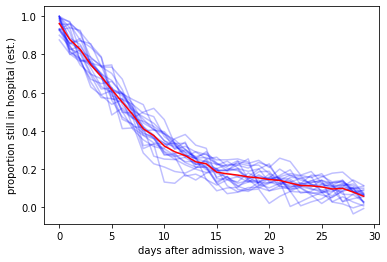

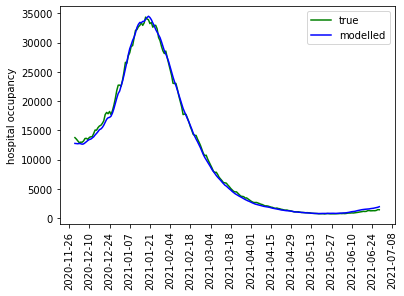

In [21]:
plt.clf()
x = list(range(len(pos)))
for y in admiss_occup_outputs:
    plt.plot(x, cumsumflip(y), color="blue", alpha=0.25)
y_avg_admiss_occup = []
for i in range(len(y)):
    y_avg_admiss_occup.append(np.mean(admiss_occup_outputs[:,i]))
plt.plot(x, cumsumflip(y_avg_admiss_occup), color="red", alpha=1)
plt.xlabel("days after admission, wave %d" % wave)
plt.ylabel("proportion still in hospital (est.)")
plt.savefig("admiss_occup_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

plt.clf()
true, pred = _g(np.array(y_avg_admiss_occup), admissions_stream, occupancy_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true, color="green", label="true")
plt.plot(x, pred, color="blue", label="modelled")
plt.ylabel("hospital occupancy")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(14))
plt.savefig("admiss_occup_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

admiss_occup[wave] = y_avg_admiss_occup

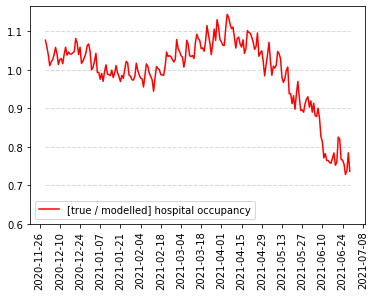

In [22]:
plt.clf()
true, pred = _g(y_avg_admiss_occup, admissions_stream, occupancy_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true/pred, color="red", label="[true / modelled] hospital occupancy")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(14))
plt.ylim(0.6,None)
y_locs,_ = plt.yticks()
plt.hlines(y_locs, x[0], x[-1], color="black", linestyles='dashed', alpha=0.15, linewidth=1)
plt.savefig("admiss_occup_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

2 0.9618363236909261 (9.19571813841295,)


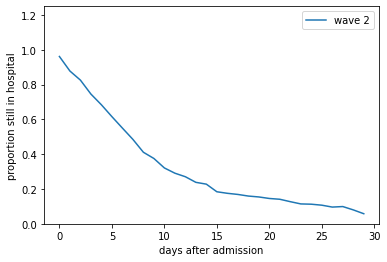

[(0, 0.08360234428809926), (1, 0.0522495642873849), (2, 0.0801036581046595), (3, 0.06172304038475916), (4, 0.06812170148670478), (5, 0.06574781914939307), (6, 0.06496987036188914), (7, 0.07403105075771053), (8, 0.035719413848817175), (9, 0.05443537566007099), (10, 0.030149451907337393), (11, 0.020383645886207318), (12, 0.03222404048180148), (13, 0.010465281586732366), (14, 0.04371962198501649), (15, 0.00886291576308236), (16, 0.006531462319237041), (17, 0.0092905668663533), (18, 0.005179486344887207), (19, 0.008711692156520474), (20, 0.004576037495053667), (21, 0.013869575022984327), (22, 0.012894130044656333), (23, 0.0016266643387665713), (24, 0.00563614657784106), (25, 0.010879151880056932), (26, -0.003001437929711601), (27, 0.01918325170989165), (28, 0.022048515926056906), (29, 0.057902284998666245)]


In [19]:
for wave,y_avg_admiss_occup in admiss_occup.items():
    print(wave, np.sum(y_avg_admiss_occup), center_of_mass(np.array(y_avg_admiss_occup)))
          
plt.clf()
x = range(n_dim)
for wave,y_avg_admiss_occup in admiss_occup.items():
    plt.plot(x, cumsumflip(y_avg_admiss_occup), label="wave %d" % wave)
plt.xlabel("days after admission")
plt.ylabel("proportion still in hospital")
plt.legend()
plt.savefig("admiss_occup_compare.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.ylim(0,1.25)
plt.show()
print(list(zip(x,y_avg_admiss_occup)))